In [2]:
# how this thing looks like when random actions are taken.
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample())
env.close()

C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\gym\envs\registration.py:564: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\gym\envs\classic_control\cartpole.py:168: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [3]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\torchvision\transforms\functional_pil.py:207: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  def resize(img, size, interpolation=Image.BILINEAR):
C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\torchvision\transforms\functional_pil.py:280: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  def perspective(img, perspective_coeffs, interpolation=Image.BICUBIC, fill=None):


In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [5]:
class DQN(nn.Module):
    def __init__(self, img_height,img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = img_height * img_width * 3, out_features = 24)
        self.fc2 = nn.Linear(in_features=24,out_features=32)
        self.out = nn.Linear(in_features=32, out_features = 2)
        
    def forward(self,t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t= F.relu(self.fc2(t))
        t = self.out(t)
        return t
        

In [6]:
# EXperience Class

In [7]:
Experience = namedtuple('Experience', ('state','action','next_state','reward'))

In [8]:
e = Experience(2,3,1,4)

In [9]:
e

Experience(state=2, action=3, next_state=1, reward=4)

In [10]:
# Replay Memory

In [11]:
class ReplayMemory():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
        
    def push(self,experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            self.push_count +=1
            
    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)
    
    def can_provide_sample(self,batch_size):
        return len(self.memory) >=batch_size             

In [12]:
# Exploration Stratergy

In [13]:
class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self,current_step):
            return self.end + (self.start - self.end) * \
                math.exp(-1. * current_step * self.decay)

In [14]:
# Reinforcement Learning Agent

In [15]:
class Agent():
    def __init__(self,strategy,num_actions,device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self,state,policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step +=1
        
        if( rate > random.random()):
            action=random.randrange(self.num_actions) # explore
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad(): # turn off gradient tracking...(check out the blog)
                return policy_net(state).argmax(dim=1).to(self.device) # exploit  

In [16]:
class CartPoleEnvManager():
    def __init__(self,device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
        
    def render(self, mode='human'):
        return self.env.render(mode) 
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self,action):
        _, reward, self.done , _ = self.env.step(action.item())
        return torch.tensor([reward],device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if (self.just_starting() or self.done):
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1 
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self,screen):
        screen_height = screen.shape[1]
        
        # strip off  top and bottom
        top = int( screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self,screen):
        # Convert to float,rescale,convert to tensor
        screen = np.ascontiguousarray(screen,dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        # Use torchvision package to compose image transforms
        resize = T.Compose([ T.ToPILImage(),T.Resize((40,90)),T.ToTensor()]) 
        
        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimen

In [17]:
## Example of non-processed screen

C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\gym\envs\registration.py:564: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


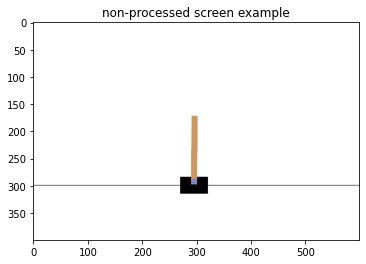

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('non-processed screen example')
plt.show()

In [ ]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0),interpolation='none')
plt.title('Processed screen example')
plt.show()

C:\Users\nvtci\Desktop\Learning DS\RL\abcdef\lib\site-packages\torch\cuda\__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 3070 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [ ]:
#Example of starting state

for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0),interpolation='none')
plt.title('Processed screen example')
plt.show()

In [ ]:
# example of end state
em.done = True
screen = em.get_state()
plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation='none')
plt.title('processed screen example')
plt.show()
em.close()

In [ ]:
def plot(values,moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period,values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)
    
def get_moving_average(period,values):
    values = torch.tensor(values,dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0,size=period,step=1) \
        .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1),moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()